The purpose of this notebook is to explore the German credit dataset and build a supervised machine learning model to predict whether a person has a good or bad credit, based on features including age, gender, housing status, career status, bank accounts information, and loan information (duration and purpose). 
<br> The dataset is from Kaggle: https://www.kaggle.com/code/bhanwarsaini/credit-risk-assessment/data which was originally from [NCI](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29).

### 1. Importing Data and Libraries

First import pandas library and upload the dataset.

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files 
uploaded = files.upload()

Saving german_credit_data.csv to german_credit_data.csv


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import fbeta_score, accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [ ]:
df = pd.read_csv('german_credit_data.csv')
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


From original dataset:
- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

First, get some basic information about this dataset:

In [ ]:
df.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


So "Saving accounts" and "Checking account" have missing values. 

In [ ]:
df.shape

(1000, 11)

In [ ]:
# Total number of records (persons)
n = df.shape[0]

# Number of people who has good credit
n_good = df[df['Risk']=='good'].shape[0]

# Number of people who has bad credit
n_bad = df[df['Risk']=='bad'].shape[0]

# Percentage of bad credit
Pr_bad = round(n_bad/n*100,2)

# Print the results
print("Total number of Records: {}".format(n))
print("Number of People with good credit: {}".format(n_good))
print("Number of People with bad credit: {}".format(n_bad))
print("Percentage of bad credit: {}%".format(Pr_bad))

Total number of Records: 1000
Number of People with good credit: 700
Number of People with bad credit: 300
Percentage of bad credit: 30.0%


There are 300 poeple with bad credit in all 1000 records in this dataset, which is 30%. So this dataset is imbalanced. 
*   In addition to accuracy, other metrics such as F-score (take beta = 1 to weigh precision and recall the same) and AUC should be considered when evaluating the supervised model.
*   In some algorithms (such as LightGBM), tell the model that the dataset is umbalanced.
*   The dataset will be resampled in a way that the minority class (bad credit) will be oversampled to 50% of the entire dataset.

### 2. Visualizing Data
Since the main task of this project is to build a ML model for predicting whether a person has a good or bad credit, I will focus on visualizing relevant information in this session. 

In [ ]:
# number of unique values in each column
df.nunique()

Unnamed: 0          1000
Age                   53
Sex                    2
Job                    4
Housing                3
Saving accounts        4
Checking account       3
Credit amount        921
Duration              33
Purpose                8
Risk                   2
dtype: int64

#### 2.1 For categorical features

In [ ]:
# map "good" and "bad" risk into "0" and "1" for percentage calculations and visualizations
df['Risk'] = df['Risk'].map({'good':0, 'bad':1})

In [ ]:
def vis_categorical(df, feature, xtick_rotate=0):
    """
    Visualization code to display 
    (left) count plot of good/bad credit in each category of the feature
    (right) percentage of bad credit in each category of the feature
    
    inputs:
      - df: dataframe
      - feature: the categorical feature to be visualize
      - xtick_rotate: whether to rotate xtick labels (default 0: not rotate; 1: rotate)
    """

    # calculate percentage
    Pr_risk = df[[feature, 'Risk']].groupby([feature], as_index = False).mean()
    Pr_risk['Risk'] = round(Pr_risk['Risk']*100, 2)
  
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize = (12,5))
    fig.subplots_adjust(wspace=0.35, hspace=0.25)

    # Aesthetics
    bar_width = 0.1
    
    # subplot 1: original counts
    ax1 = sns.countplot(df[feature], hue=df['Risk'], ax=axes[0])
    ax1.set_title("Number of Good and Bad credit people for Each {}".format(feature), fontdict={'fontsize':12})
    if xtick_rotate == 1:
      ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")

    # subplot 2: percentage of bad credits
    ax2 = sns.barplot(x=feature, y="Risk", data=Pr_risk, ax=axes[1])
    ax2.set_ylabel("Percentage of Bad credit")
    ax2.set_title("Percentage of Bad credit for Each {}".format(feature), fontdict={'fontsize':12})
    for idx, row in Pr_risk.iterrows():
      ax2.text(row.name, row.Risk, row.Risk, color='black', ha="center")
    if xtick_rotate == 1:
      ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


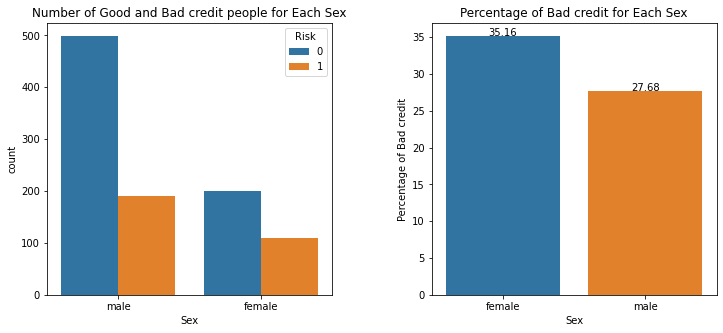

In [ ]:
vis_categorical(df, 'Sex')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


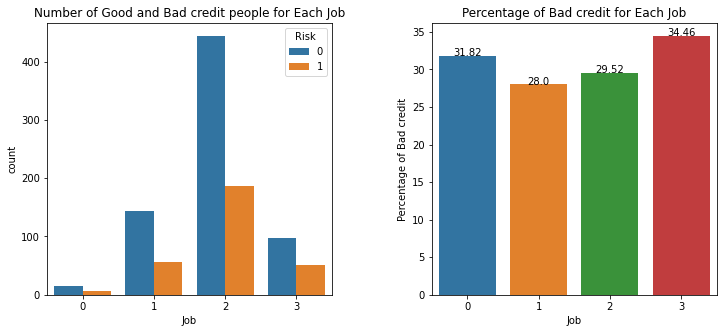

In [ ]:
vis_categorical(df, 'Job')

It's clear that in this dataset, male records have a slightly lower percentage of "bad" credit than female records. All job types have similar percentage of "bad" credit. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


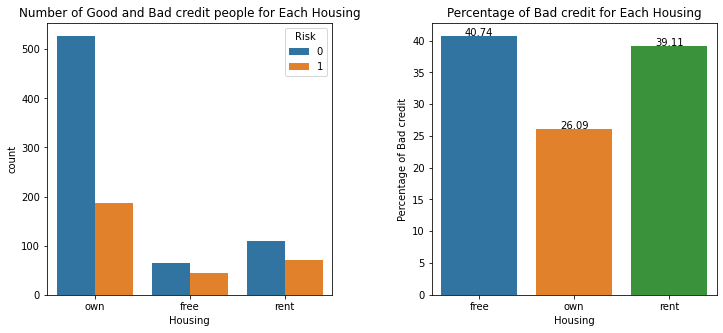

In [ ]:
vis_categorical(df, 'Housing')

People who "own" their house have the lowest percentage of "bad" credit (26%), much lower than people who "rent" or "free" in housing status (~40%).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


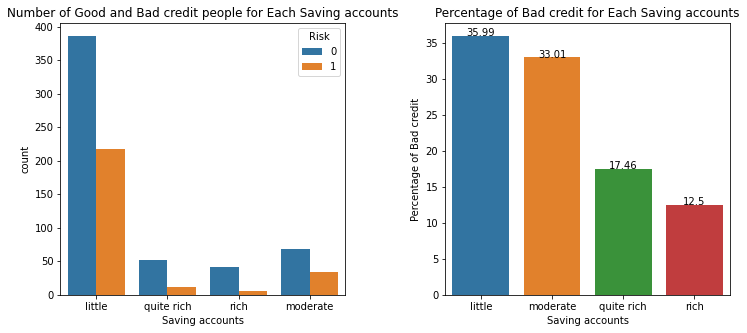

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


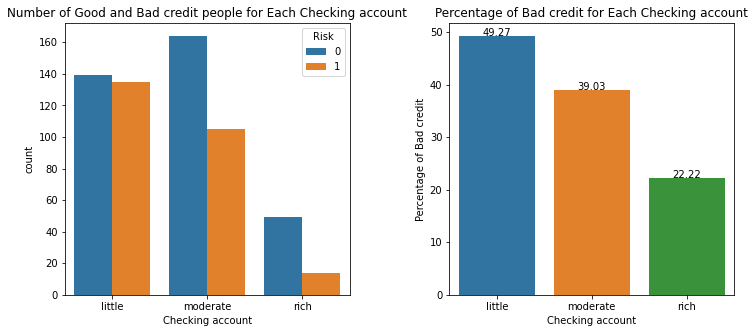

In [ ]:
vis_categorical(df, 'Saving accounts')
vis_categorical(df, 'Checking account')

Very clear that people who have high savings and checking accounts ("rich" and "quite rich") have the lowest percentage of "bad" credit.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


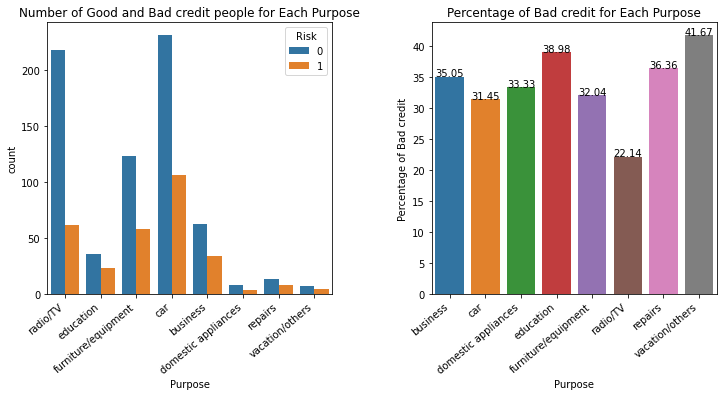

In [ ]:
vis_categorical(df, 'Purpose', 1)

It's also interesting to see that when the "purpose" is "radio/TV", the percentage of "bad" credit is the lowest (22%), and when the "purpose" is "vacation/others" or "education", the percentage of "bad" credit increases to around 40%. However, keep in mind that there are not many of records with "vacation/others" and "education". 

#### 2.2 Numerical features

In [ ]:
# calculate the percentage of bad credit at different age
Pr_risk_age = df[['Age', 'Risk']].groupby(['Age'], as_index = False).mean()
Pr_risk_age['Risk'] = round(Pr_risk_age['Risk']*100, 1)

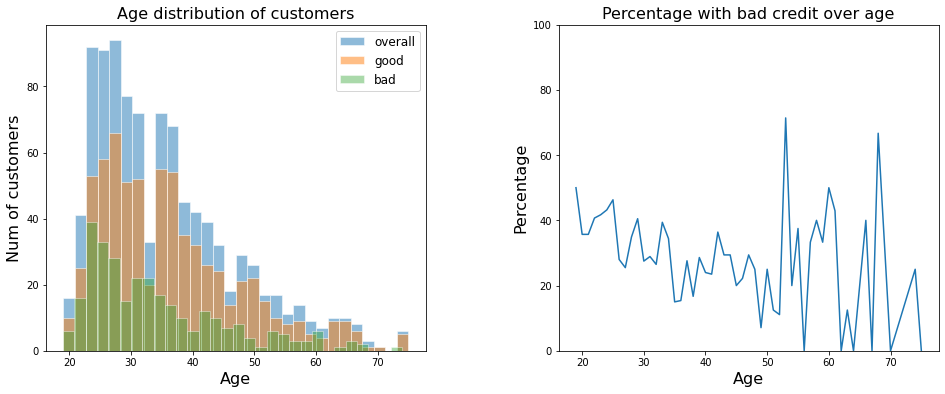

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
fig.subplots_adjust(wspace=0.35, hspace=0.25)

ax1 = axes[0]
ax1.hist(df['Age'], bins=30, alpha=0.5, ec='w', label='overall')
ax1.hist(df[df['Risk']==0]['Age'], bins=30,alpha=0.5, ec='w', label='good')
ax1.hist(df[df['Risk']==1]['Age'], bins=30,alpha=0.4, ec='w', label='bad')
ax1.set_xlabel('Age', fontsize=16)
ax1.set_ylabel('Num of customers', fontsize=16)
ax1.set_title('Age distribution of customers', fontsize=16)
ax1.legend(loc='best',fontsize=12)

ax2 = axes[1]
ax2.plot(Pr_risk_age['Age'], Pr_risk_age['Risk'])
ax2.set_title('Percentage with bad credit over age', fontsize=16)
ax2.set_xlabel('Age', fontsize=16)
ax2.set_ylabel('Percentage', fontsize=16)
ax2.set_ylim(0, 100)

plt.show()

Although there are some zig-zag (due to the small data size), overall speaking, the percentage of bad credit decreases over age, which agrees with my intuition that when people get more mature, they are more likely to be responsible for their finance and tend to have better credit. 

In [ ]:
# calculate the percentage of bad credit at different loan duration
Pr_risk_duration = df[['Duration', 'Risk']].groupby(['Duration'], as_index = False).mean()
Pr_risk_duration['Risk'] = round(Pr_risk_duration['Risk']*100, 1)

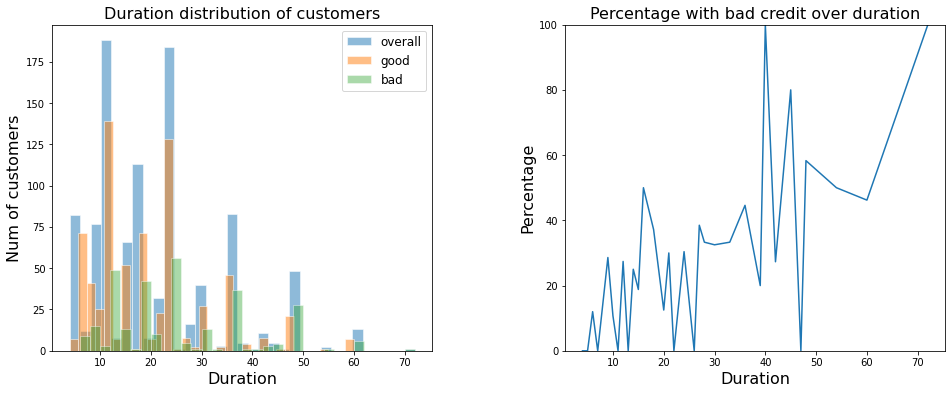

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
fig.subplots_adjust(wspace=0.35, hspace=0.25)

ax1 = axes[0]
ax1.hist(df['Duration'], bins=33, alpha=0.5, ec='w', label='overall')
ax1.hist(df[df['Risk']==0]['Duration'], bins=33,alpha=0.5, ec='w', label='good')
ax1.hist(df[df['Risk']==1]['Duration'], bins=33,alpha=0.4, ec='w', label='bad')
ax1.set_xlabel('Duration', fontsize=16)
ax1.set_ylabel('Num of customers', fontsize=16)
ax1.set_title('Duration distribution of customers', fontsize=16)
ax1.legend(loc='best',fontsize=12)

ax2 = axes[1]
ax2.plot(Pr_risk_duration['Duration'], Pr_risk_duration['Risk'])
ax2.set_title('Percentage with bad credit over duration', fontsize=16)
ax2.set_xlabel('Duration', fontsize=16)
ax2.set_ylabel('Percentage', fontsize=16)
ax2.set_ylim(0, 100)

plt.show()

Interestingly, it seems that the percentage of bad credit increases with the increasing duration.

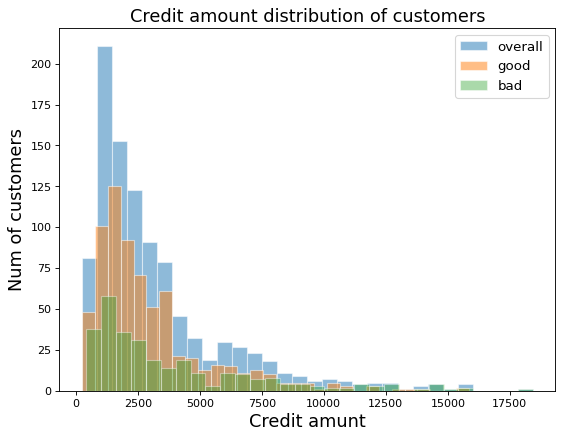

In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.hist(df['Credit amount'], bins=30, alpha=0.5, ec='w', label='overall')
plt.hist(df[df['Risk']==0]['Credit amount'], bins=30,alpha=0.5, ec='w', label='good')
plt.hist(df[df['Risk']==1]['Credit amount'], bins=30,alpha=0.4, ec='w', label='bad')
plt.xlabel('Credit amunt', fontsize=16)
plt.ylabel('Num of customers', fontsize=16)
plt.title('Credit amount distribution of customers', fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.show()

#### 2.3 Correlation diagram

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


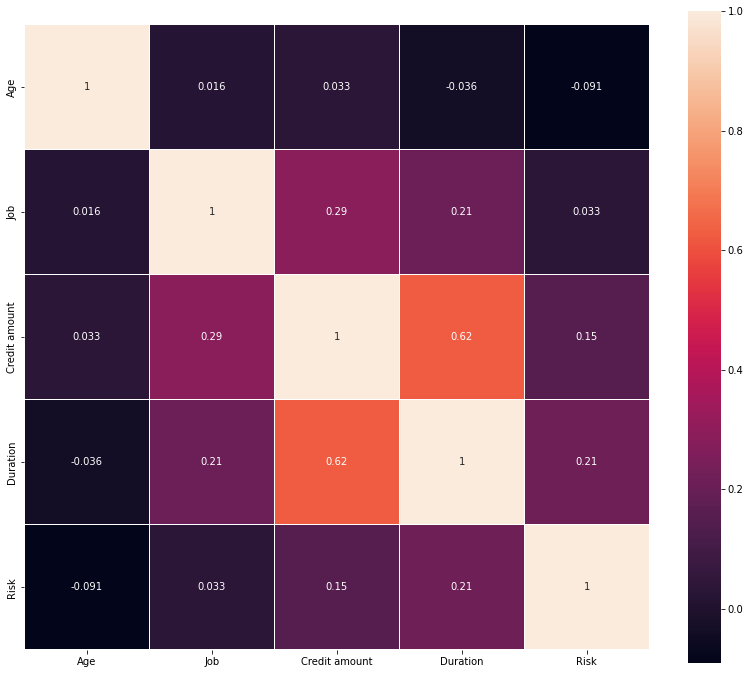

In [ ]:
plt.figure(figsize=(14,12))
#sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            #square=True,  linecolor='white', annot=True)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

### 3. Building A LightGBM Model While Missing Values Exist

#### 3.1 Checking missing data and spliting features and target label

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


In [ ]:
df.isnull().sum(axis=0)

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

From the above code, we found that there are missing values in the following 2 columns: 
*   "Saving accounts"
*   "Checking account"

<br> "Saving accounts" and "Checking account" are columns with categorical variables. 
<br>
<br> There are a few ways to deal with these missing values:
*   Given the size of our dataset and the fact that it's very easy to introduce bias, dropping these columns or rows with missing values is not practical.
*   Because I will do one-hot encoding for the categorical variables, the missing values will just be treated as all "0" in the encoded features.
*   Imputing them with ”mean", "median" or "mode" (most frequent) value of the corresponding column, or a certain constant value (easy and fast, but will probably introduce inaccuracy).
*   Some ML algorithms, such as XGBoost or LightGBM, can deal with missing data.
*   Advanced imputation techniques that uses ML algorithms to impute missing values, these techniques include knn and MICE (Multiple Imputation by Chained Equations); however, they're not suitable in this project because they only work for numerical missing values.

So in the following, I will 
1.   do feature engineering for columns without missing values
2.   build a ML model using LightGBM to see how accurate it is without one-hot encoding (LightGBM can deal with it as well) and with missing values
3.   perform one-hot encoding for all categorical features
4.   build and evaluate ML models using 9 commonly used supervised learning algorithms
5.   fill out missing values in "Checking account" and "Saving accounts" with constant "missing", re-do feature engineering, over-sample the minority class using SMOTE technique, then re-train the ML models in 4

Now let's split the data into features and target label.

In [ ]:
target = df['Risk']

In [ ]:
features_raw = df.drop(['Risk'], axis=1)

In [ ]:
features_raw.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


There are 3 numerical features (age, credit amount, and duration), and 6 categorical features (sex, job, housing, saving accounts, checking account, purpose).

In [ ]:
df['Purpose'].value_counts()

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64

In [ ]:
# mapping text categorical features into int values
features_raw['Housing'] = features_raw['Housing'].map({'free':1, 'rent':2, 'own': 3})
features_raw['Sex'] = features_raw['Sex'].map({'female':0, 'male':1})
features_raw['Saving accounts'] = features_raw['Saving accounts'].map({'little':1, 'moderate':2, 'quite rich': 3, 'rich': 4})
features_raw['Checking account'] = features_raw['Checking account'].map({'little':1, 'moderate':2, 'quite rich': 3, 'rich': 4})
features_raw['Purpose'] = features_raw['Purpose'].map({'radio/TV':1, 'education':2, 'furniture/equipment': 3, 'car': 4, 'business':5, 'domestic appliances':6, 'repairs': 7, 'vacation/others': 8})

#### 3.2 Building a LightGBM model when missing values exist

Split training set and testing set

In [ ]:
# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_raw, 
                                                    target,
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 800 samples.
Testing set has 200 samples.


Build LightGBM model (with cross validation)

In [ ]:
def lgbcv(X_train, y_train, params, n_fold=5):
  """
    Incorporate cross-validation (CV) into the lgb model
    
    inputs:
      - X_train: features for training
      - y_train: labels for training
      - params: parameters for booster
      - n_fold: Number of folds in CV
    """

  train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=["Sex", "Job", "Housing", "Saving accounts", "Checking account", "Purpose"])
  model_cv = lgb.cv(params, nfold=n_fold, train_set=train_data, categorical_feature=["Sex", "Job", "Housing", "Saving accounts", "Checking account", "Purpose"])
  return model_cv

In [ ]:
def eval_cv(X_train, y_train, n_leaves, max_depth, learning_rate, bagging_fraction):
  """
    Implement and evaluate performance of cross-validation (CV) to find the optimal parameters
    
    inputs:
      - X_train: features for training
      - y_train: labels for training
    Lists of parameters to be tuned:
      - n_leaves: max number of leaves in one tree
      - max_depth: limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
      - learning_rate: shrinkage rate
      - bagging_fraction: randomly select a subset of features on each iteration (tree) w/o resampling
    """

  metric_result = 0
  para_result = {}

  for i in n_leaves:
    for j in max_depth:
      for k in learning_rate:
        for m in bagging_fraction:

          parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'num_leaves': i,
              'max_depth': j,
              'feature_fraction': 0.8,
              'bagging_fraction': m, 
              'bagging_freq': 20,
              'learning_rate': k,
              'verbose': 5}
          model = lgbcv(X_train, y_train, params=parameters)

          if max(model['auc-mean']) > metric_result:
            metric_result = max(model['auc-mean'])
            para_result['n_leaves'] = i
            para_result['max_depth'] = j
            para_result['learning_rate'] = k
            para_result['bagging_fraction'] = m
  return metric_result, para_result

In [ ]:
n_leaves = [2, 4, 8, 12, 16]
max_depth = [2, 3, 4] # lower max_depth eliminate overfitting
learning_rate = [0.01, 0.05, 0.1]
bagging_fraction = [0.2, 0.4, 0.6, 0.8]

# optimized AUC result and corresponding parameters:
r_auc, r_para = eval_cv(X_train, y_train, n_leaves, max_depth, learning_rate, bagging_fraction)
print(r_auc, r_para)

0.7661989795918368 {'n_leaves': 8, 'max_depth': 3, 'learning_rate': 0.1, 'bagging_fraction': 0.8}


In [ ]:
parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'num_leaves': r_para['n_leaves'],
              'max_depth': r_para['max_depth'],
              'feature_fraction': 0.8,
              'bagging_fraction': r_para['bagging_fraction'], 
              'bagging_freq': 20,
              'learning_rate': r_para['learning_rate'],
              'verbose': 5}

train_data = lgb.Dataset(X_train, label=y_train)

model_lgb = lgb.train(parameters, 
                      train_data,
                      num_boost_round = 500)

In [ ]:
y_train_pred = model_lgb.predict(X_train)
y_test_pred = model_lgb.predict(X_test)
print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                   roc_auc_score(y_test, y_test_pred)))

AUC Train: 0.9836
AUC Test: 0.7379


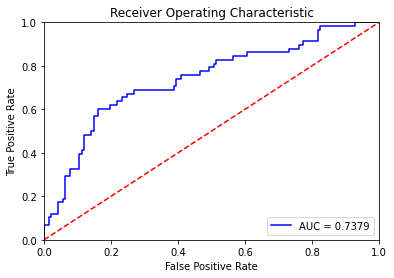

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# convert into binary values:
for i in range(len(y_test_pred)):
  if y_test_pred[i] > 0.95:
    y_test_pred[i] = 1
  else:
    y_test_pred[i] = 0
  
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("F-score on testing data: {:.4f} (beta=1)".format(fbeta_score(y_test, y_test_pred, beta = 1)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, y_test_pred)))

Accuracy score on testing data: 0.7300
F-score on testing data: 0.1290 (beta=1)
Precision on testing data: 1.0000
Recall on testing data: 0.0690


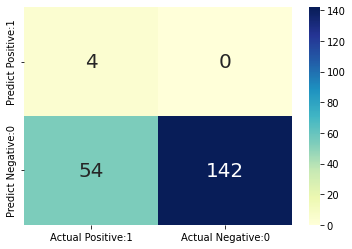

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix as a heat map
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# In binary classification, the count of true negatives is C_00, false negatives is C_10, true positives is C_11 and false positives is C_01.
cm_matrix = pd.DataFrame(data=[[cm[1,1],cm[0,1]], [cm[1,0],cm[0,0]]], columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"fontsize":20})

The model performed very badly: despite it has a reasonable accuracy for the testing set (0.73), it only caught 4 positive records out of 58 positive records in the testing set.

### 4. Preparing Data for Modeling

#### 4.1 Encoding categorical data

In [ ]:
features_raw2 = df.drop(columns=['Risk'], axis=1)

In [ ]:
features_raw2.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [ ]:
features_raw2 = features_raw2.merge(pd.get_dummies(data=features_raw2, columns=['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']))
features_raw2.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_female,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,male,2,own,NaN,little,1169,6,radio/TV,0,...,0,0,0,0,0,0,0,1,0,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1,...,1,0,0,0,0,0,0,1,0,0
2,49,male,1,own,little,NaN,2096,12,education,0,...,0,0,0,0,0,1,0,0,0,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0,...,0,0,0,0,0,0,1,0,0,0
4,53,male,2,free,little,little,4870,24,car,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
features_encoded = features_raw2.drop(columns=['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], axis=1)
features_encoded.head()

,Age,Credit amount,Duration,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,1169,6,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,22,5951,48,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,49,2096,12,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,45,7882,42,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,53,4870,24,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
features_encoded.loc[0]

Age                              67
Credit amount                  1169
Duration                          6
Sex_female                        0
Sex_male                          1
Job_0                             0
Job_1                             0
Job_2                             1
Job_3                             0
Housing_free                      0
Housing_own                       1
Housing_rent                      0
Saving accounts_little            0
Saving accounts_moderate          0
Saving accounts_quite rich        0
Saving accounts_rich              0
Checking account_little           1
Checking account_moderate         0
Checking account_rich             0
Purpose_business                  0
Purpose_car                       0
Purpose_domestic appliances       0
Purpose_education                 0
Purpose_furniture/equipment       0
Purpose_radio/TV                  1
Purpose_repairs                   0
Purpose_vacation/others           0
Name: 0, dtype: int64

We can see that through one-hot encoding, the missing value in the "Saving accounts" of the first record is gone (it just becomes 0 for all 4 newly generated columns of "Saving accounts").

#### 4.2 Normalizing Numerical Features
Normalization ensures that each feature is treated equally when applying supervised learners. This is especially important for the current dataset because the scale for each numerical column varies a lot.

In [ ]:
features_encoded.head()

,Age,Credit amount,Duration,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,1169,6,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,22,5951,48,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,49,2096,12,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,45,7882,42,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,53,4870,24,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Initialize a scaler, then apply it to the numeric features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['Age', 'Credit amount', 'Duration']

features_normalized = pd.DataFrame(data = features_encoded)
features_normalized[numerical] = scaler.fit_transform(features_normalized[numerical])
features_normalized.head()

,Age,Credit amount,Duration,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0.857143,0.050567,0.029412,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.053571,0.313690,0.647059,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0.535714,0.101574,0.117647,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.464286,0.419941,0.558824,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0.607143,0.254209,0.294118,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


#### 4.3 Splitting data into training and testing sets
We will split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [ ]:
# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, 
                                                    target,
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 800 samples.
Testing set has 200 samples.


### 5. Training and Evaluating Supervised ML Models

To predict whether a person has a good or bad credit is a supervised learning classification task. I think the three most suitable algorithms are:
*   Light Gradient Boosting Machine (lightgbm) 
*   Logistic Regression
*   Naive Bayes
*   k-nearest neighbors (knn)
*   Support Vector Machine (SVM)
*   Random Forest
*   Adaboost
*   Gradient Boost
*   XGBoost



#### 5.1 Training the LightGBM model with cross validation

In [ ]:
def lgbcv2(X_train, y_train, params, n_fold=5):
  """
    Incorporate cross-validation (CV) into the lgb model
    
    inputs:
      - X_train: features for training
      - y_train: labels for training
      - params: parameters for booster
      - n_fold: Number of folds in CV
    """

  train_data = lgb.Dataset(X_train, label=y_train)
  model_cv = lgb.cv(params, nfold=n_fold, train_set=train_data)
  return model_cv

In [ ]:
def eval_cv2(X_train, y_train, n_leaves, max_depth, learning_rate, bagging_fraction):
  """
    Implement and evaluate performance of cross-validation (CV) to find the optimal parameters
    
    inputs:
      - X_train: features for training
      - y_train: labels for training
    Lists of parameters to be tuned:
      - n_leaves: max number of leaves in one tree
      - max_depth: limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
      - learning_rate: shrinkage rate
      - bagging_fraction: randomly select a subset of features on each iteration (tree) w/o resampling
    """

  metric_result = 0
  para_result = {}

  for i in n_leaves:
    for j in max_depth:
      for k in learning_rate:
        for m in bagging_fraction:

          parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'num_leaves': i,
              'max_depth': j,
              'feature_fraction': 0.8,
              'bagging_fraction': m, 
              'bagging_freq': 20,
              'learning_rate': k,
              'verbose': 5}
          model = lgbcv2(X_train, y_train, params=parameters)

          if max(model['auc-mean']) > metric_result:
            metric_result = max(model['auc-mean'])
            para_result['n_leaves'] = i
            para_result['max_depth'] = j
            para_result['learning_rate'] = k
            para_result['bagging_fraction'] = m
  return metric_result, para_result


In [ ]:
n_leaves = [4, 6, 8, 10]
max_depth = [2, 3, 4] # lower max_depth eliminate overfitting
learning_rate = [0.01, 0.05, 0.1]
bagging_fraction = [0.4, 0.6, 0.8]

# optimized AUC result and corresponding parameters:
r_auc, r_para = eval_cv2(X_train, y_train, n_leaves, max_depth, learning_rate, bagging_fraction)
print(r_auc, r_para)

0.7647219445210517 {'n_leaves': 4, 'max_depth': 3, 'learning_rate': 0.1, 'bagging_fraction': 0.8}


Now we can use the tuned parameters to train the training dataset and make predictions on the testing dataset. 

In [ ]:
parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'num_leaves': r_para['n_leaves'],
              'max_depth': r_para['max_depth'],
              'feature_fraction': 0.8,
              'bagging_fraction': r_para['bagging_fraction'], 
              'bagging_freq': 20,
              'learning_rate': r_para['learning_rate'],
              'verbose': 5}

train_data = lgb.Dataset(X_train, label=y_train)

model_lgb = lgb.train(parameters, 
                      train_data,
                      num_boost_round = 500)

#### 5.2 Evaluating the LightGBM model

Make predictions and calculate AUC score:

In [ ]:
y_train_pred = model_lgb.predict(X_train)
y_test_pred = model_lgb.predict(X_test)
print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                   roc_auc_score(y_test, y_test_pred)))

AUC Train: 0.9496
AUC Test: 0.7328


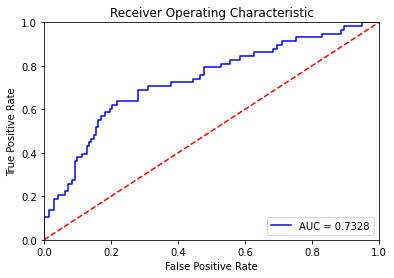

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Calculate accuracy, F-score (set beta=0.5 to weigh precision higher), precision and recall on testing set:

In [ ]:
# convert into binary values:
for i in range(len(y_test_pred)):
  if y_test_pred[i] > 0.95:
    y_test_pred[i] = 1
  else:
    y_test_pred[i] = 0
  
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("F-score on testing data: {:.4f} (beta=1)".format(fbeta_score(y_test, y_test_pred, beta = 1)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, y_test_pred)))

Accuracy score on testing data: 0.7200
F-score on testing data: 0.0667 (beta=1)
Precision on testing data: 1.0000
Recall on testing data: 0.0345


Create confusion matrix:

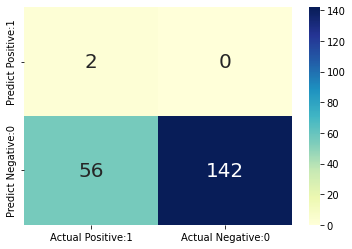

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix as a heat map
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# In binary classification, the count of true negatives is C_00, false negatives is C_10, true positives is C_11 and false positives is C_01.
cm_matrix = pd.DataFrame(data=[[cm[1,1],cm[0,1]], [cm[1,0],cm[0,0]]], columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"fontsize":20})

After a simple "one-hot" encoding, the LightGBM model still performed badly: it only caught 2 out of 58 positive records in the testing set. LightGMB is prone to overfit small dataset. 

#### 5.3 Building and Evaluating other common supervised ML models

First, define a few "utilities" functions:

In [ ]:
def grid_search(model, parameters, X_train, y_train):
  """
    Incorporate grid search to the model to find the best set of hypoparameters
    
    inputs:
      - model: model used in the grid search
      - X_train: features for training
      - y_train: labels for training
      - parameters: parameters for booster
  """

  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=0, scoring='f1')
  # set verbose = 0 to avoid long print of the result; if we want to see all details, just set it to 2
  # scoring methods: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter


  #Fitting the grid 
  grid.fit(X_train,y_train)

  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: \n', grid.best_params_)

  return optimal_model

In [ ]:
def check_scores(model, X_train, X_test):
  # Making predictions on train and test data
  """
    Make predictions on train and test dataset
    
    inputs:
      - X_train: features for training
      - y_train: labels for training
    Lists of parameters to be tuned:
      - n_leaves: max number of leaves in one tree
      - max_depth: limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
      - learning_rate: shrinkage rate
      - bagging_fraction: randomly select a subset of features on each iteration (tree) w/o resampling
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  """

  train_class_preds = model.predict(X_train)
  test_class_preds = model.predict(X_test)

  # Get the probabilities on train and test
  train_preds = model.predict_proba(X_train)[:,1]
  test_preds = model.predict_proba(X_test)[:,1]
  
  # Calculating accuracy on train and test
  train_accuracy = accuracy_score(y_train,train_class_preds)
  test_accuracy = accuracy_score(y_test,test_class_preds)

  print("The accuracy on train dataset is", train_accuracy)
  print("The accuracy on test dataset is", test_accuracy)
  
  # Get the confusion matrices for train and test
  train_cm = confusion_matrix(y_train,train_class_preds)
  test_cm = confusion_matrix(y_test,test_class_preds )

  print('\nTrain confusion matrix:')
  print( train_cm)
  print('\nTest confusion matrix:')
  print(test_cm)

  # Get the roc_auc score for train and test dataset
  train_auc = roc_auc_score(y_train,train_preds)
  test_auc = roc_auc_score(y_test,test_preds)

  print('\nAUC on train data:', train_auc)
  print('AUC on test data:', test_auc)
  
  # Fscore, precision and recall on test data
  f1 = fbeta_score(y_test, test_class_preds, beta=1)
  precision = precision_score(y_test, test_class_preds)
  recall = recall_score(y_test, test_class_preds) 
  
  
  #R2 score on train and test data
  train_log = log_loss(y_train,train_preds)
  test_log = log_loss(y_test, test_preds)

  print('\nTrain log loss:', train_log)
  print('Test log loss:', test_log)
  print("\nF score is:",f1 )
  print("Precision is:",precision)
  print("Recall is:", recall)
  return model, train_auc, test_auc, train_accuracy, test_accuracy,f1, precision,recall, train_log, test_log

In [ ]:
def check_importance(model, X_train):
  """
    Check importance of features in prediction
    
    inputs:
      - X_train: features for training
      - y_train: labels for training
    Lists of parameters to be tuned:
      - n_leaves: max number of leaves in one tree
      - max_depth: limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
      - learning_rate: shrinkage rate
      - bagging_fraction: randomly select a subset of features on each iteration (tree) w/o resampling
  """


  importances = model.feature_importances_
  
  #List of columns and their importances
  importance_dict = {'Feature' : list(X_train.columns),
                    'Feature Importance' : importances}
  #Creating a dataframe
  importance_df = pd.DataFrame(importance_dict)
  
  #Rounding it off to 2 digits as we might get exponential numbers
  importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)
  return importance_df.sort_values(by=['Feature Importance'],ascending=False)

# This gives feature importance
def plot_feature_importance(model, X_train):
  # PLotting features vs their importance factors
  fig = plt.figure(figsize = (15, 8))
  
  # Extracting importance values
  values =check_importance(model, X_train)[check_importance(model, X_train)['Feature Importance']>0]['Feature Importance'].values
  
  
  # Extracting importance features
  features = check_importance(model, X_train)[check_importance(model, X_train)['Feature Importance']>0]['Feature'].values

  plt.bar(features, values, color ='blue',
          width = 0.4)
  plt.xticks( rotation='vertical')
  plt.show()

##### 5.3.1 Logistic Regression:

In [ ]:
# Parameter grid for Logistic Regression
solvers = ['lbfgs']
penalty = ['l2']
c_values = [200, 100, 10, 1.0, 0.1]
lr_parameters = dict(solver=solvers,penalty=penalty,C=c_values)# define grid search

#finding the best model
lr_optimal_model = grid_search(LogisticRegression(max_iter=5000), lr_parameters, X_train, y_train)

Best parameters are: 
 {'C': 200, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
lr_model, lr_train_auc, lr_test_auc, lr_train_accuracy, lr_test_accuracy,lr_f1, lr_precision, lr_recall,lr_train_log, lr_test_log = check_scores(lr_optimal_model, X_train, X_test )

The accuracy on train dataset is 0.75
The accuracy on test dataset is 0.71

Train confusion matrix:
[[501  57]
 [143  99]]

Test confusion matrix:
[[118  24]
 [ 34  24]]

AUC on train data: 0.7784812938771883
AUC on test data: 0.7526711996114619

AUC on train data (class): 0.6534701857282502
AUC on test data: 0.6223895094706168
TEST

AUC on train data (class): 0.6534701857282502
AUC on test data: 0.6223895094706168

Train log loss: 8.634751070044572
Test log loss: 10.016341106215721

F score is: 0.4528301886792453
Precision is: 0.5
Recall is: 0.41379310344827586


##### 5.3.2 Naive Bayes (GaussianNB):

In [ ]:
# Parameter grid for GaussianNB
var_smoothing_lst = [5e-11, 1e-10, 5e-10, 1e-9]
gnb_parameters = {'var_smoothing': var_smoothing_lst}
print(gnb_parameters)


#finding the best model
gnb_optimal_model = grid_search(GaussianNB(), gnb_parameters, X_train, y_train)

{'var_smoothing': [5e-11, 1e-10, 5e-10, 1e-09]}
Best parameters are: 
 {'var_smoothing': 5e-11}


In [ ]:
gnb_model, gnb_train_auc, gnb_test_auc, gnb_train_accuracy, gnb_test_accuracy,gnb_f1, gnb_precision, gnb_recall, gnb_train_log, gnb_test_log = check_scores(gnb_optimal_model, X_train, X_test)

The accuracy on train dataset is 0.67875
The accuracy on test dataset is 0.67

Train confusion matrix:
[[416 142]
 [115 127]]

Test confusion matrix:
[[110  32]
 [ 34  24]]

AUC on train data: 0.6981471607571315
AUC on test data: 0.6812773190869353

AUC on train data (class): 0.6351565508457004
AUC on test data: 0.5942204953861098
TEST

AUC on train data (class): 0.6351565508457004
AUC on test data: 0.5942204953861098

Train log loss: 11.095723845408916
Test log loss: 11.397924145909355

F score is: 0.42105263157894735
Precision is: 0.42857142857142855
Recall is: 0.41379310344827586


##### 5.3.3 knn:

In [ ]:
# Parameter grid for knn
n_neighbors_lst = [1, 2, 3, 4, 5, 8] 
weights_lst = ['uniform', 'distance'] 
knn_parameters = {'n_neighbors': n_neighbors_lst,
              'weights': weights_lst}
print(knn_parameters)

#finding the best model
knn_optimal_model = grid_search(KNeighborsClassifier(), knn_parameters, X_train, y_train)

{'n_neighbors': [1, 2, 3, 4, 5, 8], 'weights': ['uniform', 'distance']}
Best parameters are: 
 {'n_neighbors': 3, 'weights': 'distance'}


In [ ]:
knn_model, knn_train_auc, knn_test_auc, knn_train_accuracy, knn_test_accuracy, knn_f1, knn_precision, knn_recall, knn_train_log, knn_test_log = check_scores(knn_optimal_model, X_train, X_test)

The accuracy on train dataset is 1.0
The accuracy on test dataset is 0.655

Train confusion matrix:
[[558   0]
 [  0 242]]

Test confusion matrix:
[[110  32]
 [ 37  21]]

AUC on train data: 1.0
AUC on test data: 0.6008377853326858

AUC on train data (class): 1.0
AUC on test data: 0.5683584264205924
TEST

AUC on train data (class): 1.0
AUC on test data: 0.5683584264205924

Train log loss: 9.992007221626413e-16
Test log loss: 11.916005791833017

F score is: 0.37837837837837834
Precision is: 0.39622641509433965
Recall is: 0.3620689655172414


##### 5.3.4 Support Vector Machine (SVM):

In [ ]:
# Parameter grid for SVC
kernels = ['linear', 'poly', 'rbf'] 
gammas = ['scale', 'auto', 5]
C_values = [0.01, 0.05, 0.1, 1, 10]
svc_parameters = {'kernel': kernels,
              'gamma': gammas,
              'C': C_values}
print(svc_parameters)

#finding the best model
svc_optimal_model = grid_search(SVC(probability=True), svc_parameters, X_train, y_train)

{'kernel': ['linear', 'poly', 'rbf'], 'gamma': ['scale', 'auto', 5], 'C': [0.01, 0.05, 0.1, 1, 10]}
Best parameters are: 
 {'C': 0.01, 'gamma': 5, 'kernel': 'poly'}


In [ ]:
svc_model, svc_train_auc, svc_test_auc, svc_train_accuracy, svc_test_accuracy,svc_f1, svc_precision,svc_recall,svc_train_log, svc_test_log = check_scores(svc_optimal_model, X_train, X_test)

The accuracy on train dataset is 0.94
The accuracy on test dataset is 0.65

Train confusion matrix:
[[546  12]
 [ 36 206]]

Test confusion matrix:
[[103  39]
 [ 31  27]]

AUC on train data: 0.9665052282354335
AUC on test data: 0.622510927634774

AUC on train data (class): 0.9148671465387008
AUC on test data: 0.5954346770276833
TEST

AUC on train data (class): 0.9148671465387008
AUC on test data: 0.5954346770276833

Train log loss: 2.0723385776560947
Test log loss: 12.088727659717629

F score is: 0.43548387096774194
Precision is: 0.4090909090909091
Recall is: 0.46551724137931033


##### 5.3.5 Random Forest model:

In [ ]:
# Number of trees
n_estimators = [30, 50, 80, 100]

# Maximum depth of trees
max_depth = [2, 3, 4]

# Minimum number of samples required to split a node
min_samples_split = [25, 50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [30, 40, 50]

# Hyperparameter Grid
rf_parameters = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

print(rf_parameters)

#finding the best model
rf_optimal_model = grid_search(RandomForestClassifier(), rf_parameters, X_train, y_train)

{'n_estimators': [30, 50, 80, 100], 'max_depth': [2, 3, 4], 'min_samples_split': [25, 50, 100, 150], 'min_samples_leaf': [30, 40, 50]}
Best parameters are: 
 {'max_depth': 4, 'min_samples_leaf': 30, 'min_samples_split': 25, 'n_estimators': 30}


In [ ]:
rf_model, rf_train_auc, rf_test_auc, rf_train_accuracy, rf_test_accuracy,rf_f1, rf_precision,rf_recall,rf_train_log, rf_test_log = check_scores(rf_optimal_model, X_train, X_test)

The accuracy on train dataset is 0.7175
The accuracy on test dataset is 0.725

Train confusion matrix:
[[556   2]
 [224  18]]

Test confusion matrix:
[[142   0]
 [ 55   3]]

AUC on train data: 0.783357771260997
AUC on test data: 0.7234094220495386

AUC on train data (class): 0.5353979679492875
AUC on test data: 0.5258620689655172
TEST

AUC on train data (class): 0.5353979679492875
AUC on test data: 0.5258620689655172

Train log loss: 9.757206330555844
Test log loss: 9.498163508600438

F score is: 0.09836065573770492
Precision is: 1.0
Recall is: 0.05172413793103448


##### 5.3.6 Adaboost:

In [ ]:
adb_parameters ={
    "n_estimators":[50,100,200,250],
    "learning_rate":[0.1,0.2,0.5,1]
}

print(adb_parameters)

adb_optimal_model = grid_search(AdaBoostClassifier(), adb_parameters, X_train, y_train)

{'n_estimators': [50, 100, 200, 250], 'learning_rate': [0.1, 0.2, 0.5, 1]}
Best parameters are: 
 {'learning_rate': 0.2, 'n_estimators': 250}


In [ ]:
adb_model, adb_train_auc, adb_test_auc, adb_train_accuracy, adb_test_accuracy, adb_f1, adb_precision, adb_recall, adb_train_log, adb_test_log = check_scores(adb_optimal_model, X_train, X_test)

The accuracy on train dataset is 0.785
The accuracy on test dataset is 0.75

Train confusion matrix:
[[513  45]
 [127 115]]

Test confusion matrix:
[[127  15]
 [ 35  23]]

AUC on train data: 0.827516366006102
AUC on test data: 0.749453618261292

AUC on train data (class): 0.6972807251399626
AUC on test data: 0.6454589606605149
TEST

AUC on train data (class): 0.6972807251399626
AUC on test data: 0.6454589606605149

Train log loss: 7.425881902261244
Test log loss: 8.634754068534935

F score is: 0.47916666666666674
Precision is: 0.6052631578947368
Recall is: 0.39655172413793105


##### 5.3.7 Gradient boost:

In [ ]:
gb_parameters ={
    "n_estimators":[5,50,100,250],
    "max_depth":[3,5,7,9],
    "min_samples_split": [2,3,4],
    "min_samples_leaf": [2,3,4],
    "learning_rate":[0.01,0.1,0.5]
}

print(gb_parameters)

gb_optimal_model = grid_search(GradientBoostingClassifier(), gb_parameters, X_train, y_train)

{'n_estimators': [5, 50, 100, 250], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [2, 3, 4], 'learning_rate': [0.01, 0.1, 0.5]}
Best parameters are: 
 {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50}


In [ ]:
gb_model, gb_train_auc, gb_test_auc, gb_train_accuracy, gb_test_accuracy,gb_f1, gb_precision,gb_recall,gb_train_log, gb_test_log = check_scores(gb_optimal_model, X_train, X_test )

The accuracy on train dataset is 0.99875
The accuracy on test dataset is 0.72

Train confusion matrix:
[[558   0]
 [  1 241]]

Test confusion matrix:
[[118  24]
 [ 32  26]]

AUC on train data: 1.0
AUC on test data: 0.6952404079650316

AUC on train data (class): 0.9979338842975207
AUC on test data: 0.6396308887809616
TEST

AUC on train data (class): 0.9979338842975207
AUC on test data: 0.6396308887809616

Train log loss: 0.04317347049363935
Test log loss: 9.670953342266616

F score is: 0.48148148148148145
Precision is: 0.52
Recall is: 0.4482758620689655


##### 5.3.8 XGBoost:

In [ ]:
# Parameter grid for xgboost
xgb_parameters ={
    "n_estimators":[5,10,50,100],
    "max_depth":[3,5,7],
    "min_samples_split": [2,3,4],
    "min_samples_leaf": [2,3,4],
    "learning_rate":[0.01,0.1,0.5,1]
}

print(xgb_parameters)
#finding the best model
xgb_optimal_model = grid_search(XGBClassifier(), xgb_parameters, X_train, y_train)

{'n_estimators': [5, 10, 50, 100], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [2, 3, 4], 'learning_rate': [0.01, 0.1, 0.5, 1]}
Best parameters are: 
 {'learning_rate': 0.5, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


In [ ]:
xgb_model, xgb_train_auc, xgb_test_auc, xgb_train_accuracy, xgb_test_accuracy,xgb_f1, xgb_precision,xgb_recall,xgb_train_log, xgb_test_log= check_scores(xgb_optimal_model, X_train, X_test )

The accuracy on train dataset is 0.955
The accuracy on test dataset is 0.76

Train confusion matrix:
[[552   6]
 [ 30 212]]

Test confusion matrix:
[[122  20]
 [ 28  30]]

AUC on train data: 0.9910542373885481
AUC on test data: 0.7266877124817873

AUC on train data (class): 0.9326401848395983
AUC on test data: 0.6881981544439048
TEST

AUC on train data (class): 0.9326401848395983
AUC on test data: 0.6881981544439048

Train log loss: nan
Test log loss: nan

F score is: 0.5555555555555556
Precision is: 0.6
Recall is: 0.5172413793103449


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Create a dataframe to show all metric scores for every model built:

In [ ]:
scores_ = [("Logistic Regression", lr_train_auc, lr_test_auc, lr_train_accuracy, lr_test_accuracy,lr_train_log, lr_test_log,lr_f1, lr_precision, lr_recall,),
           ("Gaussian Naive Bayes", gnb_train_auc, gnb_test_auc, gnb_train_accuracy, gnb_test_accuracy,gnb_train_log, gnb_test_log, gnb_f1, gnb_precision, gnb_recall),
           ("knn", knn_train_auc, knn_test_auc, knn_train_accuracy, knn_test_accuracy,knn_train_log, knn_test_log,knn_f1, knn_precision, knn_recall),
           ("SVC", svc_train_auc, svc_test_auc, svc_train_accuracy, svc_test_accuracy,svc_train_log, svc_test_log,svc_f1, svc_precision, svc_recall),
           ("Random Forest", rf_train_auc, rf_test_auc, rf_train_accuracy, rf_test_accuracy,rf_train_log, rf_test_log,rf_f1, rf_precision, rf_recall),
           ("AdaBoost",  adb_train_auc, adb_test_auc, adb_train_accuracy, adb_test_accuracy, adb_train_log, adb_test_log, adb_f1, adb_precision, adb_recall),
           ("Gradient Boosting",  gb_train_auc, gb_test_auc, gb_train_accuracy, gb_test_accuracy,gb_train_log, gb_test_log,gb_f1, gb_precision,gb_recall),
           ("XG Boost", xgb_train_auc, xgb_test_auc, xgb_train_accuracy, xgb_test_accuracy,xgb_train_log, xgb_test_log,xgb_f1, xgb_precision, xgb_recall)]


Scores_ =pd.DataFrame(data = scores_, columns=['Model Name', 'Train ROC', 'Test ROC', 'Train Accuracy', 'Test Accuracy', 'Train Log Loss','Test Log Loss','F-Score', 'Precision','Recall',])
Scores_.set_index('Model Name', inplace = True)



In [ ]:
Scores_

,Train ROC,Test ROC,Train Accuracy,Test Accuracy,Train Log Loss,Test Log Loss,F-Score,Precision,Recall
Model Name,,,,,,,,,
Logistic Regression,0.778481,0.752671,0.75000,0.710,8.634751e+00,10.016341,0.452830,0.500000,0.413793
Gaussian Naive Bayes,0.698147,0.681277,0.67875,0.670,1.109572e+01,11.397924,0.421053,0.428571,0.413793
knn,1.000000,0.600838,1.00000,0.655,9.992007e-16,11.916006,0.378378,0.396226,0.362069
SVC,0.966505,0.622511,0.94000,0.650,2.072339e+00,12.088728,0.435484,0.409091,0.465517
Random Forest,0.783358,0.723409,0.71750,0.725,9.757206e+00,9.498164,0.098361,1.000000,0.051724
AdaBoost,0.827516,0.749454,0.78500,0.750,7.425882e+00,8.634754,0.479167,0.605263,0.396552
Gradient Boosting,1.000000,0.695240,0.99875,0.720,4.317347e-02,9.670953,0.481481,0.520000,0.448276
XG Boost,0.991054,0.726688,0.95500,0.760,NaN,NaN,0.555556,0.600000,0.517241


From the table, the model works best (without imputing missing values) is XGBoost. Other models that show a higher-than-average performance are:
*   AdaBoost
*   Gradient Boosting
*   Logistic Regression
*   SVC
*   Gaussian Naive Bayes




### 6. Imputation and Feature Engineering

#### 6.1 Imputating missing values with "missing" and encoding categorical features

In [ ]:
features_raw3 = df.drop(columns=['Risk'], axis=1)
features_raw3.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [ ]:
features_raw3.fillna('missing', inplace=True)
features_raw3.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,missing,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,missing,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [ ]:
features_raw3 = features_raw3.merge(pd.get_dummies(data=features_raw3, columns=['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']))
features_raw3.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_female,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,male,2,own,missing,little,1169,6,radio/TV,0,...,0,0,0,0,0,0,0,1,0,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1,...,1,0,0,0,0,0,0,1,0,0
2,49,male,1,own,little,missing,2096,12,education,0,...,0,0,0,0,0,1,0,0,0,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0,...,0,0,0,0,0,0,1,0,0,0
4,53,male,2,free,little,little,4870,24,car,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
features_encoded3 = features_raw3.drop(columns=['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], axis=1)
features_encoded3.head()

,Age,Credit amount,Duration,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,1169,6,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,22,5951,48,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,49,2096,12,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,45,7882,42,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,53,4870,24,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
features_encoded3.loc[0]

Age                              67
Credit amount                  1169
Duration                          6
Sex_female                        0
Sex_male                          1
Job_0                             0
Job_1                             0
Job_2                             1
Job_3                             0
Housing_free                      0
Housing_own                       1
Housing_rent                      0
Saving accounts_little            0
Saving accounts_missing           1
Saving accounts_moderate          0
Saving accounts_quite rich        0
Saving accounts_rich              0
Checking account_little           1
Checking account_missing          0
Checking account_moderate         0
Checking account_rich             0
Purpose_business                  0
Purpose_car                       0
Purpose_domestic appliances       0
Purpose_education                 0
Purpose_furniture/equipment       0
Purpose_radio/TV                  1
Purpose_repairs             

#### 6.2 Normalizing numerical features

In [ ]:
# Initialize a scaler, then apply it to the numeric features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['Age', 'Credit amount', 'Duration']

features_normalized3 = pd.DataFrame(data = features_encoded3)
features_normalized3[numerical] = scaler.fit_transform(features_normalized3[numerical])
features_normalized3.head()

,Age,Credit amount,Duration,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0.857143,0.050567,0.029412,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.053571,0.313690,0.647059,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0.535714,0.101574,0.117647,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.464286,0.419941,0.558824,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0.607143,0.254209,0.294118,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


#### 6.3 Over-sampling
Over-sampling increases the number of instances in the minority class (risk=1; bad) by SMOTE technique. Unlike under-sampling , over-sampling lead to no information loss. SMOTE technique usually works better than randomly oversampling, because it can eliminate overfitting of repeating samples.

In [ ]:
sm = SMOTE(random_state=0) # sampling_strategy=0.25) # 0.25 is the majority/minority ratio after resampling
X_resampled, y_resampled = sm.fit_resample(features_normalized3, target)

In [ ]:
X_resampled.shape

(1400, 29)

In [ ]:
y_resampled.sum()

700

So here the minority class (risk=1) has been oversampled to 700, which has the same amount as the majority class (risk=0).

#### 6.4 Splitting data into training and testing sets

In [ ]:
# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, 
                                                    y_resampled,
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1120 samples.
Testing set has 280 samples.


### 7. Training and Evaluating Supervised ML Models (after imputation and oversampling)

#### 7.1 Building and Evaluating supervised ML models

##### 7.1.1 Logistic Regression:

In [ ]:
# Parameter grid for Logistic Regression
solvers = ['lbfgs']
penalty = ['l2']
c_values = [300, 200, 100, 10, 1.0, 0.1]
lr_parameters = dict(solver=solvers,penalty=penalty,C=c_values)# define grid search

#finding the best model
lr_optimal_model = grid_search(LogisticRegression(max_iter=5000), lr_parameters, X_train, y_train)

Best parameters are: 
 {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
lr_model, lr_train_auc, lr_test_auc, lr_train_accuracy, lr_test_accuracy,lr_f1, lr_precision, lr_recall,lr_train_log, lr_test_log = check_scores(lr_optimal_model, X_train, X_test )

The accuracy on train dataset is 0.8169642857142857
The accuracy on test dataset is 0.7857142857142857

Train confusion matrix:
[[460  99]
 [106 455]]

Test confusion matrix:
[[116  25]
 [ 35 104]]

AUC on train data: 0.8912847298620212
AUC on test data: 0.8412674116026326

Train log loss: 0.4072054259146461
Test log loss: 0.48326170410426794

F score is: 0.7761194029850746
Precision is: 0.8062015503875969
Recall is: 0.7482014388489209


##### 7.1.2 Naive Bayes (GaussianNB):

In [ ]:
# Parameter grid for GaussianNB
var_smoothing_lst = [5e-11, 1e-10, 5e-10, 1e-9, 5e-9]
gnb_parameters = {'var_smoothing': var_smoothing_lst}
print(gnb_parameters)


#finding the best model
gnb_optimal_model = grid_search(GaussianNB(), gnb_parameters, X_train, y_train)

{'var_smoothing': [5e-11, 1e-10, 5e-10, 1e-09, 5e-09]}
Best parameters are: 
 {'var_smoothing': 1e-09}


In [ ]:
gnb_model, gnb_train_auc, gnb_test_auc, gnb_train_accuracy, gnb_test_accuracy,gnb_f1, gnb_precision, gnb_recall, gnb_train_log, gnb_test_log = check_scores(gnb_optimal_model, X_train, X_test)

The accuracy on train dataset is 0.7348214285714286
The accuracy on test dataset is 0.7285714285714285

Train confusion matrix:
[[358 201]
 [ 96 465]]

Test confusion matrix:
[[ 97  44]
 [ 32 107]]

AUC on train data: 0.7813768538802738
AUC on test data: 0.7569773968059595

Train log loss: 1.5551595420433655
Test log loss: 1.4142796250851997

F score is: 0.7379310344827585
Precision is: 0.7086092715231788
Recall is: 0.7697841726618705


##### 7.1.3 knn:

In [ ]:
# Parameter grid for knn
n_neighbors_lst = [1, 2, 3, 4, 5, 8] 
weights_lst = ['uniform', 'distance'] 
knn_parameters = {'n_neighbors': n_neighbors_lst,
              'weights': weights_lst}
print(knn_parameters)

#finding the best model
knn_optimal_model = grid_search(KNeighborsClassifier(), knn_parameters, X_train, y_train)

{'n_neighbors': [1, 2, 3, 4, 5, 8], 'weights': ['uniform', 'distance']}
Best parameters are: 
 {'n_neighbors': 3, 'weights': 'distance'}


In [ ]:
knn_model, knn_train_auc, knn_test_auc, knn_train_accuracy, knn_test_accuracy, knn_f1, knn_precision, knn_recall, knn_train_log, knn_test_log = check_scores(knn_optimal_model, X_train, X_test)

The accuracy on train dataset is 1.0
The accuracy on test dataset is 0.7464285714285714

Train confusion matrix:
[[559   0]
 [  0 561]]

Test confusion matrix:
[[ 98  43]
 [ 28 111]]

AUC on train data: 1.0
AUC on test data: 0.81266901372519

Train log loss: 3.6097827756637205e-10
Test log loss: 3.1491082555789505

F score is: 0.757679180887372
Precision is: 0.7207792207792207
Recall is: 0.7985611510791367


##### 7.1.4 Support Vector Machine (SVM):

In [ ]:
# Parameter grid for SVC
kernels = ['linear', 'poly', 'rbf'] 
gammas = ['scale', 'auto', 5, 10]
C_values = [0.005, 0.01, 0.05, 0.1, 1, 10]
svc_parameters = {'kernel': kernels,
              'gamma': gammas,
              'C': C_values}
print(svc_parameters)

#finding the best model
svc_optimal_model = grid_search(SVC(probability=True), svc_parameters, X_train, y_train)

{'kernel': ['linear', 'poly', 'rbf'], 'gamma': ['scale', 'auto', 5, 10], 'C': [0.005, 0.01, 0.05, 0.1, 1, 10]}
Best parameters are: 
 {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [ ]:
svc_model, svc_train_auc, svc_test_auc, svc_train_accuracy, svc_test_accuracy,svc_f1, svc_precision,svc_recall,svc_train_log, svc_test_log = check_scores(svc_optimal_model, X_train, X_test)

The accuracy on train dataset is 0.8107142857142857
The accuracy on test dataset is 0.75

Train confusion matrix:
[[457 102]
 [110 451]]

Test confusion matrix:
[[111  30]
 [ 40  99]]

AUC on train data: 0.884478266831208
AUC on test data: 0.832848614725241

Train log loss: 0.4219042474702623
Test log loss: 0.4938993714518895

F score is: 0.7388059701492538
Precision is: 0.7674418604651163
Recall is: 0.7122302158273381


##### 7.1.5 Random Forest model:

In [ ]:
# Number of trees
n_estimators = [20, 30, 50, 80]

# Maximum depth of trees
max_depth = [2, 3, 4]

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4, 10]

# Hyperparameter Grid
rf_parameters = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

print(rf_parameters)

#finding the best model
rf_optimal_model = grid_search(RandomForestClassifier(), rf_parameters, X_train, y_train)

{'n_estimators': [20, 30, 50, 80], 'max_depth': [2, 3, 4], 'min_samples_split': [2, 3, 4, 10], 'min_samples_leaf': [2, 3, 4, 10]}
Best parameters are: 
 {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 80}


In [ ]:
rf_model, rf_train_auc, rf_test_auc, rf_train_accuracy, rf_test_accuracy,rf_f1, rf_precision,rf_recall,rf_train_log, rf_test_log = check_scores(rf_optimal_model, X_train, X_test)

The accuracy on train dataset is 0.78125
The accuracy on test dataset is 0.7285714285714285

Train confusion matrix:
[[401 158]
 [ 87 474]]

Test confusion matrix:
[[100  41]
 [ 35 104]]

AUC on train data: 0.8556564274758529
AUC on test data: 0.7635848767794274

Train log loss: 0.5217245466174786
Test log loss: 0.5873010902652513

F score is: 0.7323943661971832
Precision is: 0.7172413793103448
Recall is: 0.7482014388489209


##### 7.1.6 Adaboost:

In [ ]:
adb_parameters ={
    "n_estimators":[100,200,250,300],
    "learning_rate":[0.1,0.2,0.5,1]
}

print(adb_parameters)

adb_optimal_model = grid_search(AdaBoostClassifier(), adb_parameters, X_train, y_train)

{'n_estimators': [100, 200, 250, 300], 'learning_rate': [0.1, 0.2, 0.5, 1]}
Best parameters are: 
 {'learning_rate': 0.2, 'n_estimators': 250}


In [ ]:
adb_model, adb_train_auc, adb_test_auc, adb_train_accuracy, adb_test_accuracy, adb_f1, adb_precision, adb_recall, adb_train_log, adb_test_log = check_scores(adb_optimal_model, X_train, X_test)

The accuracy on train dataset is 0.7946428571428571
The accuracy on test dataset is 0.7428571428571429

Train confusion matrix:
[[426 133]
 [ 97 464]]

Test confusion matrix:
[[108  33]
 [ 39 100]]

AUC on train data: 0.8696982452112412
AUC on test data: 0.7835348742282768

Train log loss: 0.682022727890281
Test log loss: 0.6854147704932139

F score is: 0.7352941176470588
Precision is: 0.7518796992481203
Recall is: 0.7194244604316546


##### 7.1.7 Gradient boost:

In [ ]:
gb_parameters ={
    "n_estimators":[5,50,100,250],
    "max_depth":[3,5,7,9],
    "min_samples_split": [2,3,4],
    "min_samples_leaf": [2,3,4],
    "learning_rate":[0.01,0.1,0.5]
}

print(gb_parameters)

gb_optimal_model = grid_search(GradientBoostingClassifier(), gb_parameters, X_train, y_train)

{'n_estimators': [5, 50, 100, 250], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [2, 3, 4], 'learning_rate': [0.01, 0.1, 0.5]}
Best parameters are: 
 {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 50}


In [ ]:
gb_model, gb_train_auc, gb_test_auc, gb_train_accuracy, gb_test_accuracy,gb_f1, gb_precision,gb_recall,gb_train_log, gb_test_log = check_scores(gb_optimal_model, X_train, X_test )

The accuracy on train dataset is 0.93125
The accuracy on test dataset is 0.75

Train confusion matrix:
[[504  55]
 [ 22 539]]

Test confusion matrix:
[[108  33]
 [ 37 102]]

AUC on train data: 0.9821029403792743
AUC on test data: 0.8220572478187663

Train log loss: 0.266167047012184
Test log loss: 0.5264177534069044

F score is: 0.7445255474452555
Precision is: 0.7555555555555555
Recall is: 0.7338129496402878


##### 7.1.8 XGBoost:

In [ ]:
# Parameter grid for xgboost
xgb_parameters ={
    "n_estimators":[5,10,50,100],
    "max_depth":[3,5,7],
    "min_samples_split": [2,3,4],
    "min_samples_leaf": [2,3,4],
    "learning_rate":[0.01,0.1,0.5,1]
}

print(xgb_parameters)
#finding the best model
xgb_optimal_model = grid_search(XGBClassifier(), xgb_parameters, X_train, y_train)

{'n_estimators': [5, 10, 50, 100], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [2, 3, 4], 'learning_rate': [0.01, 0.1, 0.5, 1]}
Best parameters are: 
 {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
xgb_model, xgb_train_auc, xgb_test_auc, xgb_train_accuracy, xgb_test_accuracy,xgb_f1, xgb_precision,xgb_recall,xgb_train_log, xgb_test_log= check_scores(xgb_optimal_model, X_train, X_test )

The accuracy on train dataset is 0.8178571428571428
The accuracy on test dataset is 0.7321428571428571

Train confusion matrix:
[[427 132]
 [ 72 489]]

Test confusion matrix:
[[103  38]
 [ 37 102]]

AUC on train data: 0.9064681328703217
AUC on test data: 0.8013674167049339

Train log loss: 0.423044423088764
Test log loss: 0.5492107568973942

F score is: 0.7311827956989246
Precision is: 0.7285714285714285
Recall is: 0.7338129496402878


##### 7.1.9 Comparing metrics of all models

In [ ]:
scores_ = [("Logistic Regression", lr_train_auc, lr_test_auc, lr_train_accuracy, lr_test_accuracy,lr_train_log, lr_test_log,lr_f1, lr_precision, lr_recall,),
           ("Gaussian Naive Bayes", gnb_train_auc, gnb_test_auc, gnb_train_accuracy, gnb_test_accuracy,gnb_train_log, gnb_test_log, gnb_f1, gnb_precision, gnb_recall),
           ("knn", knn_train_auc, knn_test_auc, knn_train_accuracy, knn_test_accuracy,knn_train_log, knn_test_log,knn_f1, knn_precision, knn_recall),
           ("SVC", svc_train_auc, svc_test_auc, svc_train_accuracy, svc_test_accuracy,svc_train_log, svc_test_log,svc_f1, svc_precision, svc_recall),
           ("Random Forest", rf_train_auc, rf_test_auc, rf_train_accuracy, rf_test_accuracy,rf_train_log, rf_test_log,rf_f1, rf_precision, rf_recall),
           ("AdaBoost",  adb_train_auc, adb_test_auc, adb_train_accuracy, adb_test_accuracy, adb_train_log, adb_test_log, adb_f1, adb_precision, adb_recall),
           ("Gradient Boosting",  gb_train_auc, gb_test_auc, gb_train_accuracy, gb_test_accuracy,gb_train_log, gb_test_log,gb_f1, gb_precision,gb_recall),
           ("XG Boost", xgb_train_auc, xgb_test_auc, xgb_train_accuracy, xgb_test_accuracy,xgb_train_log, xgb_test_log,xgb_f1, xgb_precision, xgb_recall)]


Scores_ =pd.DataFrame(data = scores_, columns=['Model Name', 'Train ROC', 'Test ROC', 'Train Accuracy', 'Test Accuracy', 'Train Log Loss','Test Log Loss','F-Score', 'Precision','Recall',])
Scores_.set_index('Model Name', inplace = True)


In [ ]:
Scores_

,Train ROC,Test ROC,Train Accuracy,Test Accuracy,Train Log Loss,Test Log Loss,F-Score,Precision,Recall
Model Name,,,,,,,,,
Logistic Regression,0.891285,0.841267,0.816964,0.785714,4.072054e-01,0.483262,0.776119,0.806202,0.748201
Gaussian Naive Bayes,0.781377,0.756977,0.734821,0.728571,1.555160e+00,1.414280,0.737931,0.708609,0.769784
knn,1.000000,0.812669,1.000000,0.746429,3.609783e-10,3.149108,0.757679,0.720779,0.798561
SVC,0.884478,0.832849,0.810714,0.750000,4.219042e-01,0.493899,0.738806,0.767442,0.712230
Random Forest,0.855656,0.763585,0.781250,0.728571,5.217245e-01,0.587301,0.732394,0.717241,0.748201
AdaBoost,0.869698,0.783535,0.794643,0.742857,6.820227e-01,0.685415,0.735294,0.751880,0.719424
Gradient Boosting,0.982103,0.822057,0.931250,0.750000,2.661670e-01,0.526418,0.744526,0.755556,0.733813
XG Boost,0.906468,0.801367,0.817857,0.732143,4.230444e-01,0.549211,0.731183,0.728571,0.733813


It is found that the F1-score (and therefore both precision and recall) increased dramatically from session 5. So imputing the missing values with "missing" constant, as well as SMOTE technique to oversampling the minority class, helps optimize the models. 

From the table, the model works best (after imputing the missing values with "missing" constant and oversampling the minority class with the SMOTE technique is Logistic Regression. It showed an AUC of 0.84, accuracy of 0.79, F-score of 0.78 (precision of 0.81 and recall of 0.75), and log loss of 0.48 for the testing dataset. Other models that work well are SVC and Gradient Boosting.

#### 7.2 Feature importance
For some models, we can find the importance of features that are used in predicting. 

##### 7.2.1 Random Forest:
The top 5 important features are "Checking account_missing", "Duration", "Age", "Checking account_little", and "Saving accounts_missing".

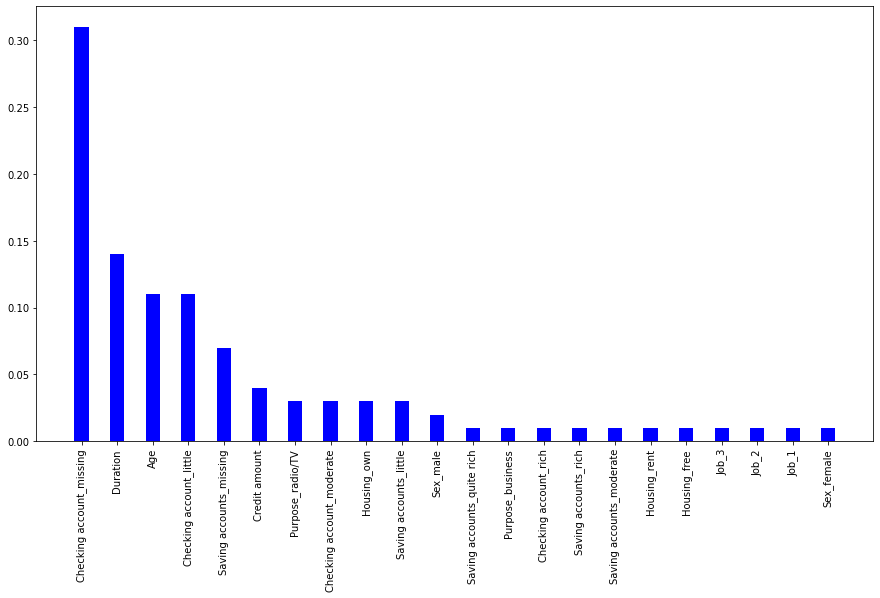

In [ ]:
plot_feature_importance(rf_optimal_model, X_train)

##### 7.2.2 Adaboost:
The top 5 important features are "Credit amount", "Duration", "Age", "Checking account_missing", and "Purpose_Radio/TV".

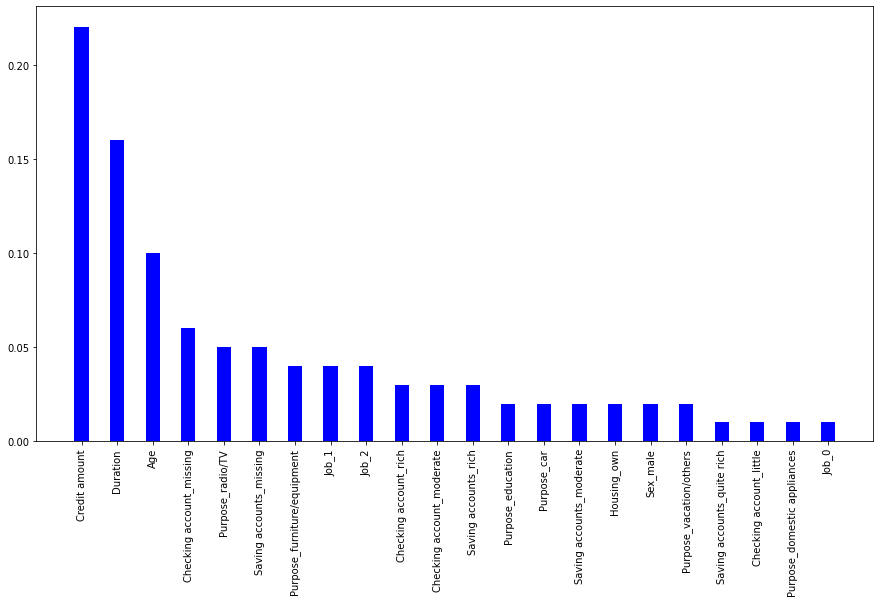

In [ ]:
plot_feature_importance(adb_optimal_model, X_train)

##### 7.2.3 Gradient boost:
The top 5 important features are "Checking account_missing", "Duration", "Credit amount", "Age", and "Saving accounts_missing".

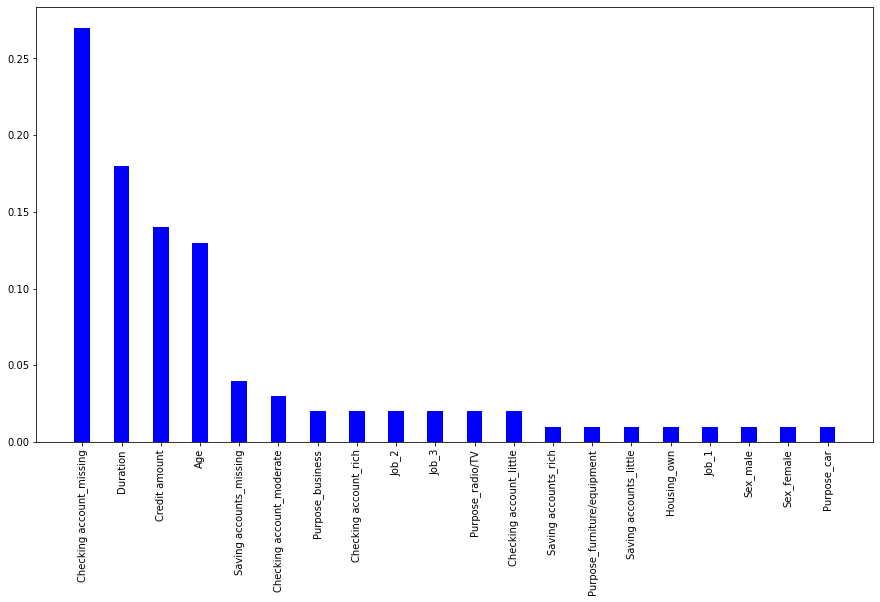

In [ ]:
plot_feature_importance(gb_optimal_model, X_train)

##### 7.2.3 XGBoost:
Here "Checking account_missing" shows a predominent effect in predicting; other important features are "Saving accounts_moderate", "Saving accounts_missing", "Duration", "Sex_male", and "Checking account_moderate".

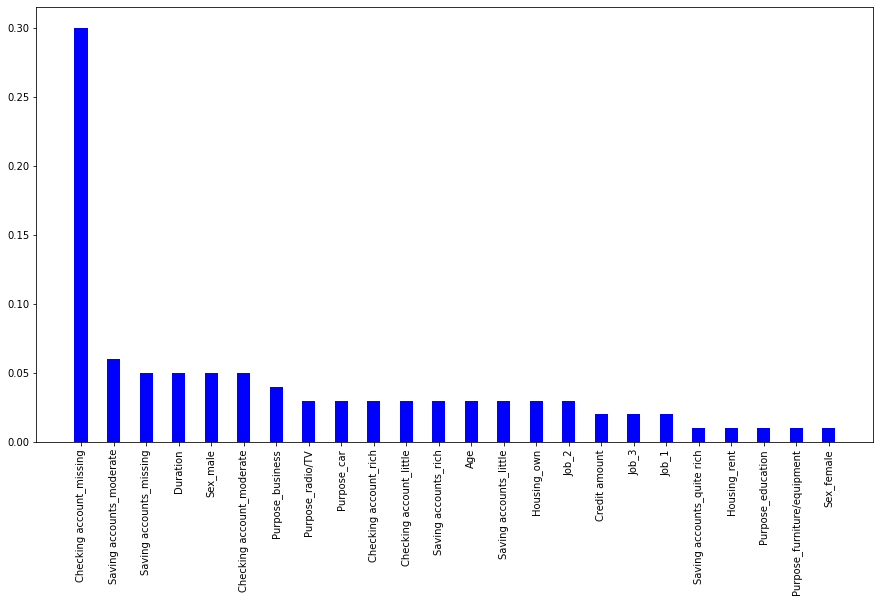

In [ ]:
plot_feature_importance(xgb_optimal_model, X_train)